# Time Series Analysis of NYC Yellow Taxi Trips

In [1]:
%pip install kagglehub
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install seaborn
%pip install statsmodels
%pip install pmdarima

DEPRECATION: google-images-search 1.4.6 has a non-standard dependency specifier click>=7.0<=8.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of google-images-search or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: google-images-search 1.4.6 has a non-standard dependency specifier click>=7.0<=8.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of google-images-search or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip 

In [2]:
import kagglehub
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima  # Per ottimizzazione automatica dei parametri

## Dataset loading

In [3]:
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")
file_path1 = os.path.join(path, "yellow_tripdata_2015-01.csv")
file_path2 = os.path.join(path, "yellow_tripdata_2016-01.csv")
file_path3 = os.path.join(path, "yellow_tripdata_2016-02.csv")
file_path4 = os.path.join(path, "yellow_tripdata_2016-03.csv")

file_paths = [
    #file_path1,
    file_path2,
    file_path3,
    file_path4]


In [4]:
# Columns of interest
columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'total_amount']

# Load the dataset into a pandas dataframe
dfs = [pd.read_csv(f, usecols=columns, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']) for f in file_paths]
df = pd.concat(dfs, ignore_index=True)

## Data cleaning

In [5]:
df.dropna(subset=columns, inplace=True)
df = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0) & (df['total_amount'] > 0)]

## Time variables creation

In [6]:
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
df = df[(df['trip_duration'] > 0) & (df['trip_duration'] < 240)]

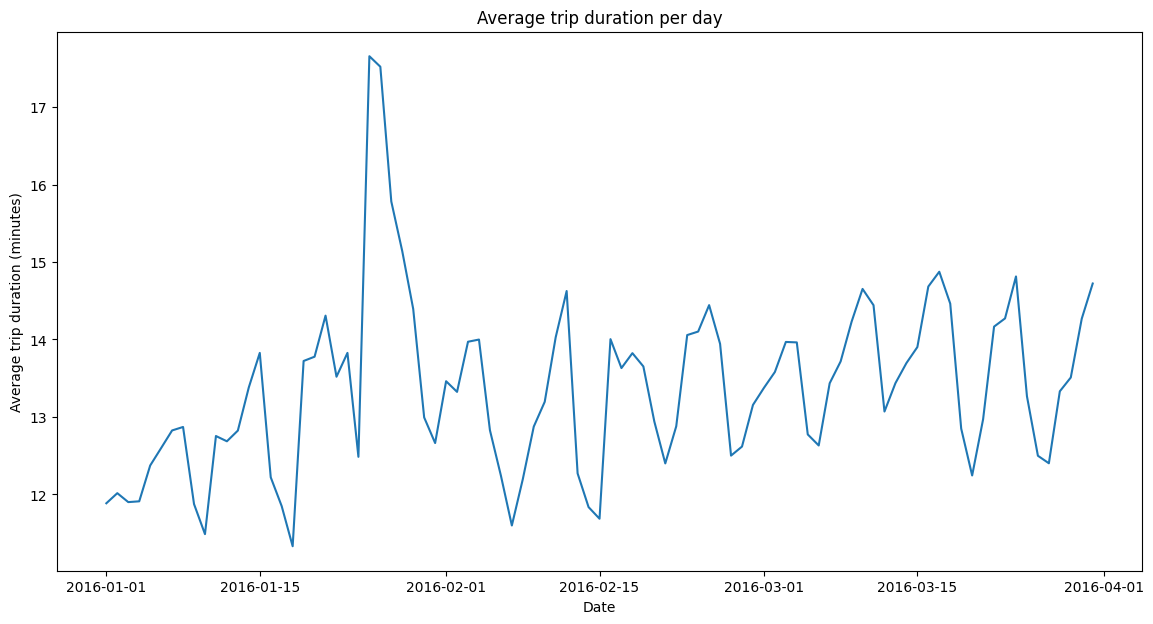

In [7]:
# Calculate the average duration of trips for each day
daily_avg_duration = df.groupby('pickup_date')['trip_duration'].mean()

# Visualize the trend of the average trip duration
plt.figure(figsize=(14, 7))
daily_avg_duration.plot()
plt.title('Average trip duration per day')
plt.xlabel('Date')
plt.ylabel('Average trip duration (minutes)')
plt.show()

## Stationarity analysis

In [19]:
daily_trips = df.groupby('pickup_date').size()

ts_daily_trips = daily_trips.copy()
ts_daily_trips.index = pd.to_datetime(ts_daily_trips.index)
ts_daily_trips = ts_daily_trips.asfreq('D', fill_value=0)

In [20]:
ts_daily_trips['2016-01-23'] = ts_daily_trips[ts_daily_trips.index.dayofweek == 5].mean()
ts_daily_trips['2016-01-24'] = ts_daily_trips[ts_daily_trips.index.dayofweek == 6].mean()
ts_daily_trips['2016-01-25'] = ts_daily_trips[ts_daily_trips.index.dayofweek == 0].mean()
ts_daily_trips['2016-01-26'] = ts_daily_trips[ts_daily_trips.index.dayofweek == 1].mean()

/var/folders/hx/spnwlsh16j34k7bqrtl81q3m0000gn/T/ipykernel_66520/2654392441.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '391149.6153846154' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ts_daily_trips['2016-01-23'] = ts_daily_trips[ts_daily_trips.index.dayofweek == 5].mean()


In [21]:
# Train and test
train_size = int(len(ts_daily_trips) * 0.8)
train_ts = ts_daily_trips[:train_size]
test_ts = ts_daily_trips[train_size:]

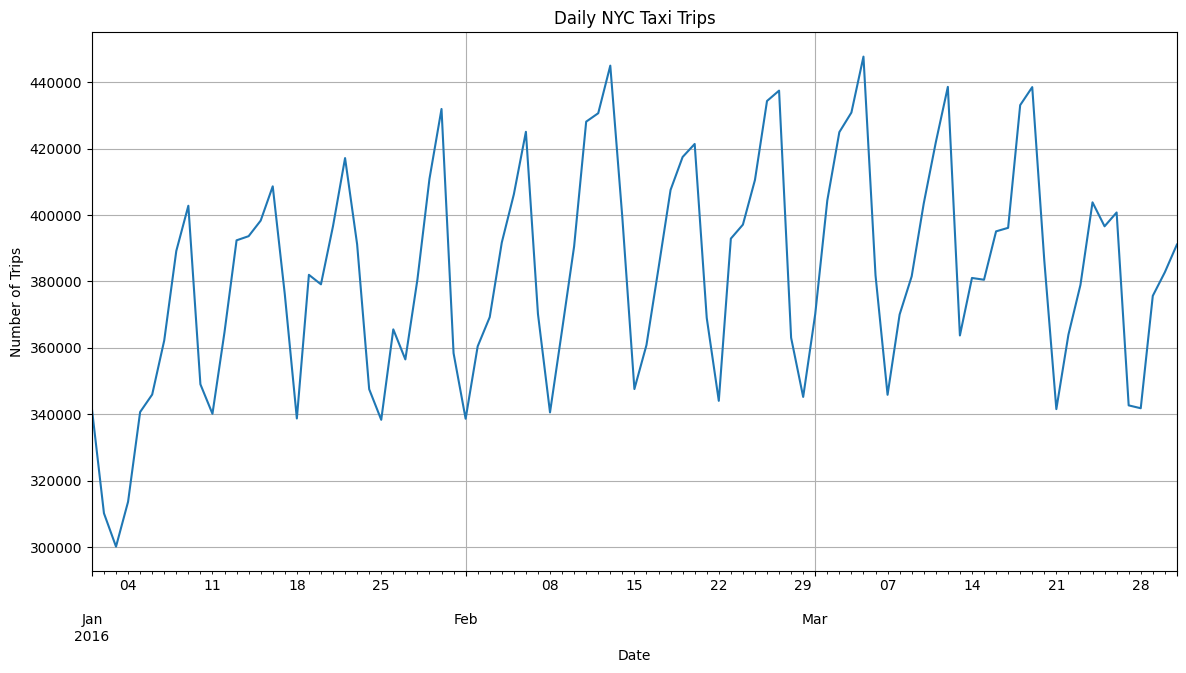

In [22]:
plt.figure(figsize=(14, 7))
ts_daily_trips.plot()
plt.title('Daily NYC Taxi Trips')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid()
plt.show()

In [23]:
def test_stationarity_with_interpretation(timeseries):
    result = adfuller(timeseries)
    print('=== Augmented Dickey-Fuller Test ===')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    # Interpretazione del risultato
    if result[1] <= 0.05:
        print("\n✅ La serie è stazionaria")
    else:
        print("\n❌ La serie NON è stazionaria")

# Test sulla serie originale
print("\n[TEST SULLA SERIE ORIGINALE]")
test_stationarity_with_interpretation(train_ts)


[TEST SULLA SERIE ORIGINALE]
=== Augmented Dickey-Fuller Test ===
ADF Statistic: -3.4416
p-value: 0.00961852901098633
Critical Values:
   1%: -3.5369
   5%: -2.9079
   10%: -2.5915

✅ La serie è stazionaria


In [13]:
# Differenziazione stagionale per catturare la periodicità settimanale
ts_daily_trips_diff = ts_daily_trips.diff(7).dropna()
print("\n[TEST SULLA SERIE DIFFERENZIATA]")
test_stationarity_with_interpretation(ts_daily_trips_diff)


[TEST SULLA SERIE DIFFERENZIATA]
=== Augmented Dickey-Fuller Test ===
ADF Statistic: -5.2218
p-value: 7.93260425003635e-06
Critical Values:
   1%: -3.5117
   5%: -2.8970
   10%: -2.5857

✅ La serie è stazionaria


The $p$-value is less than $0.05$, which means that we can reject the null hypothesis that the time series is non-stationary. The time series is stationary.

NameError: name 'ts_daily_trips_diff' is not defined

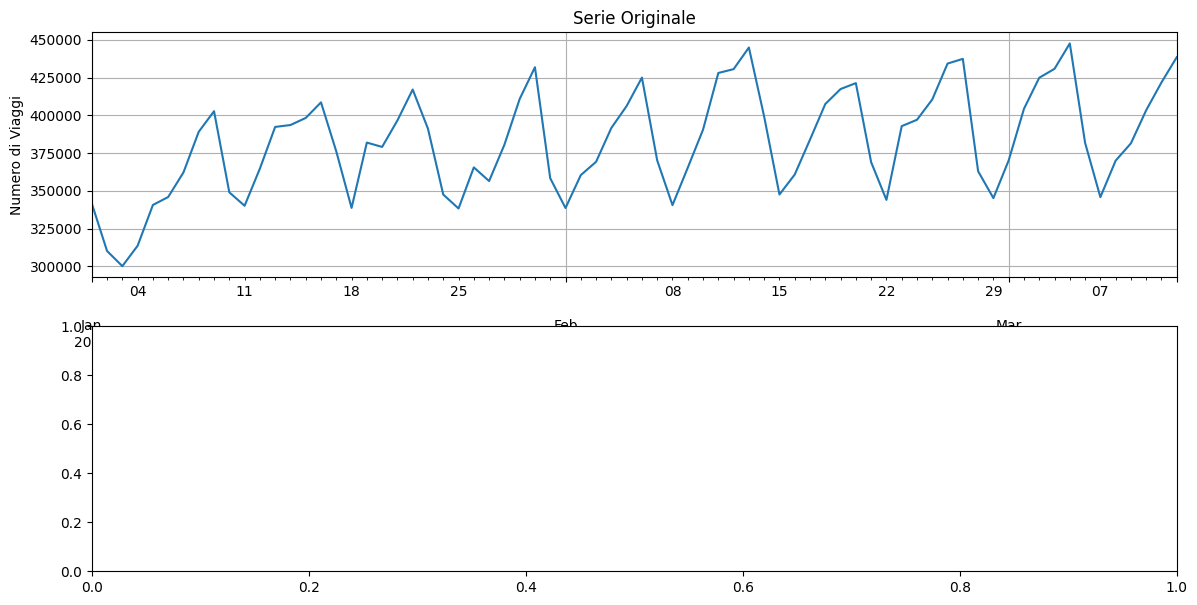

In [24]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
train_ts.plot(ax=plt.gca())
plt.title('Serie Originale')
plt.xlabel('Date')
plt.ylabel('Numero di Viaggi')
plt.grid()

plt.subplot(2, 1, 2)
ts_daily_trips_diff.plot(ax=plt.gca(), color='orange')
plt.title('Serie Differenziata (Primo Ordine)')
plt.xlabel('Date')
plt.ylabel('Differenza Numero di Viaggi')
plt.grid()
plt.tight_layout()
plt.show()

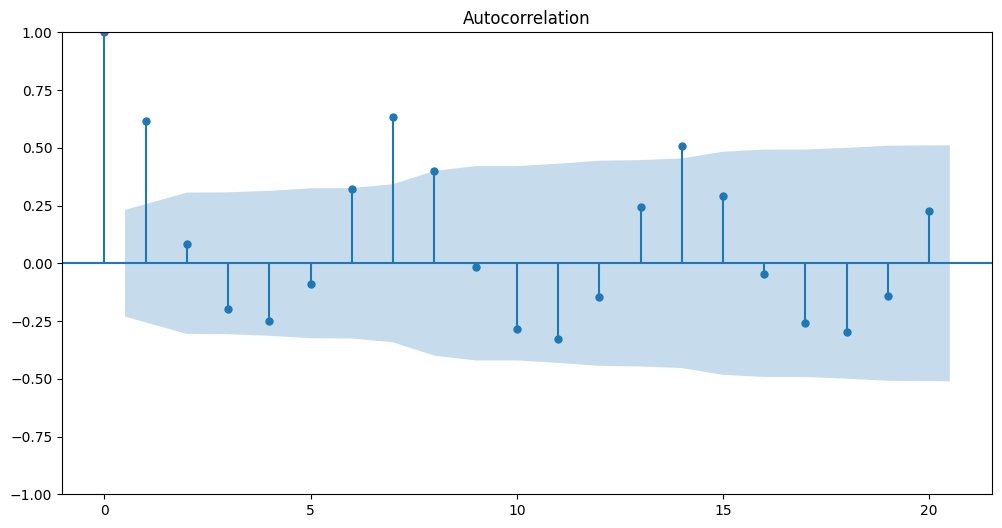

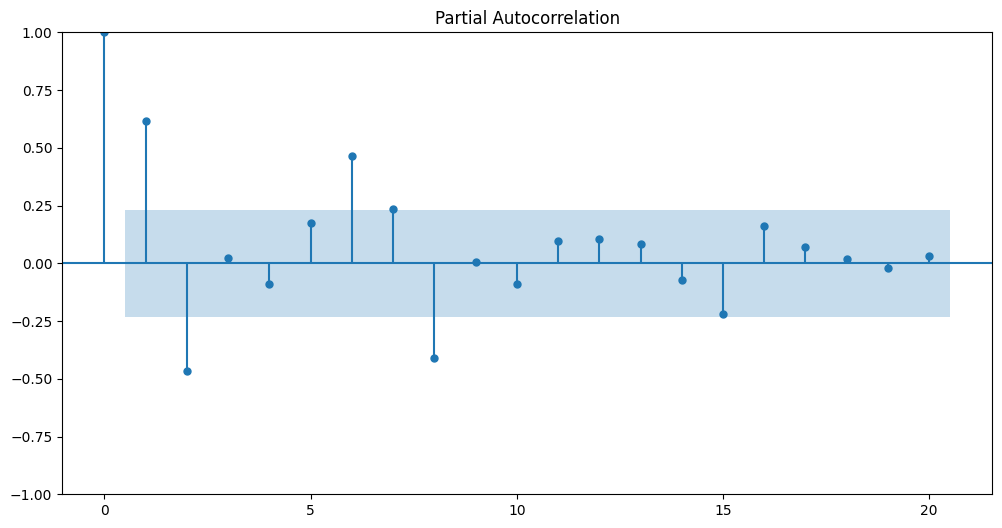

In [25]:
# Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(train_ts, ax=plt.gca(), lags=20)
plt.show()

# Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(train_ts, ax=plt.gca(), lags=20)
plt.show()

### Automatic optimization of parameters with auto_arima

In [26]:
auto_arima_model = auto_arima(train_ts, d=0, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print("Best ARIMA model:", auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2057.936, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2010.250, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1690.038, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1690.044, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1674.696, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2002.019, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1673.945, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2001.211, Time=0.01 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1673.736, Time=0.03 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1649.397, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1688.149, Time=0.04 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=1660.082, Time=0.06 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=i

In [27]:
auto_sarima_model = auto_arima(train_ts, d=0, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print("Best SARIMA model:", auto_sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=1464.015, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1487.427, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1464.663, Time=0.04 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1466.574, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1491.449, Time=0.00 sec
 ARIMA(2,0,2)(0,1,1)[7] intercept   : AIC=1462.186, Time=0.21 sec
 ARIMA(2,0,2)(0,1,0)[7] intercept   : AIC=1460.222, Time=0.06 sec
 ARIMA(2,0,2)(1,1,0)[7] intercept   : AIC=1462.199, Time=0.09 sec
 ARIMA(1,0,2)(0,1,0)[7] intercept   : AIC=1459.525, Time=0.04 sec
 ARIMA(1,0,2)(1,1,0)[7] intercept   : AIC=1460.819, Time=0.07 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=1460.854, Time=0.07 sec
 ARIMA(1,0,2)(1,1,1)[7] intercept   : AIC=1462.814, Time=0.20 sec
 ARIMA(0,0,2)(0,1,0)[7] intercept   : AIC=1475.365, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=1459.964, Time=0.01 sec
 ARIMA(1,0,3)(0,1,0)[7] intercept

## ARIMA-SARIMA models
### p, d, q parameters

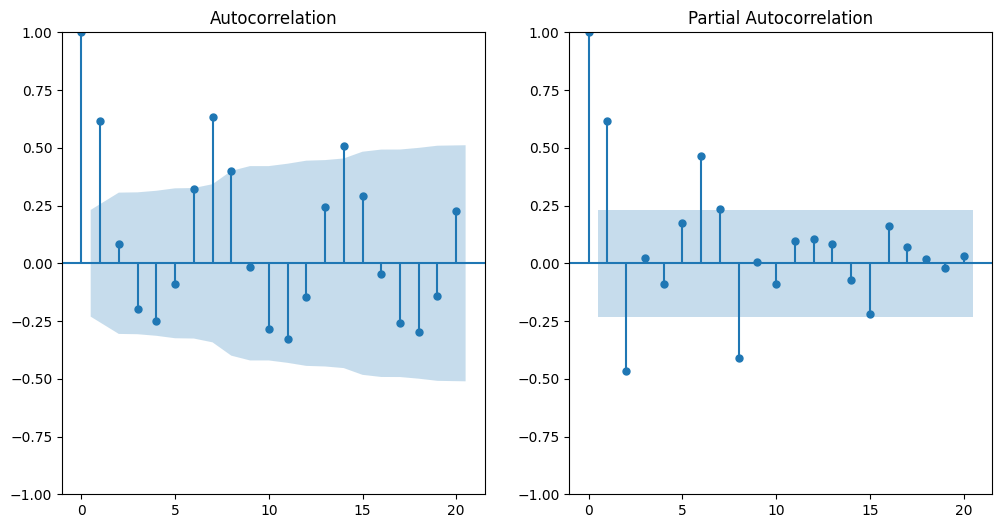

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_ts, ax=plt.gca(), lags=20)
plt.subplot(122)
plot_pacf(train_ts, ax=plt.gca(), lags=20)
plt.show()

In [41]:
model = ARIMA(train_ts, order=(1, 0, 1))

arima_fit = model.fit()

print("\n=== ARIMA Model Summary ===")
print(arima_fit.summary())


=== ARIMA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -828.204
Date:                Sun, 01 Dec 2024   AIC                           1664.408
Time:                        23:42:21   BIC                           1673.514
Sample:                    01-01-2016   HQIC                          1668.033
                         - 03-12-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.825e+05   7924.222     48.264      0.000    3.67e+05    3.98e+05
ar.L1          0.3719      0.159      2.332      0.020       0.059       0.685
ma.L1          0.6023  

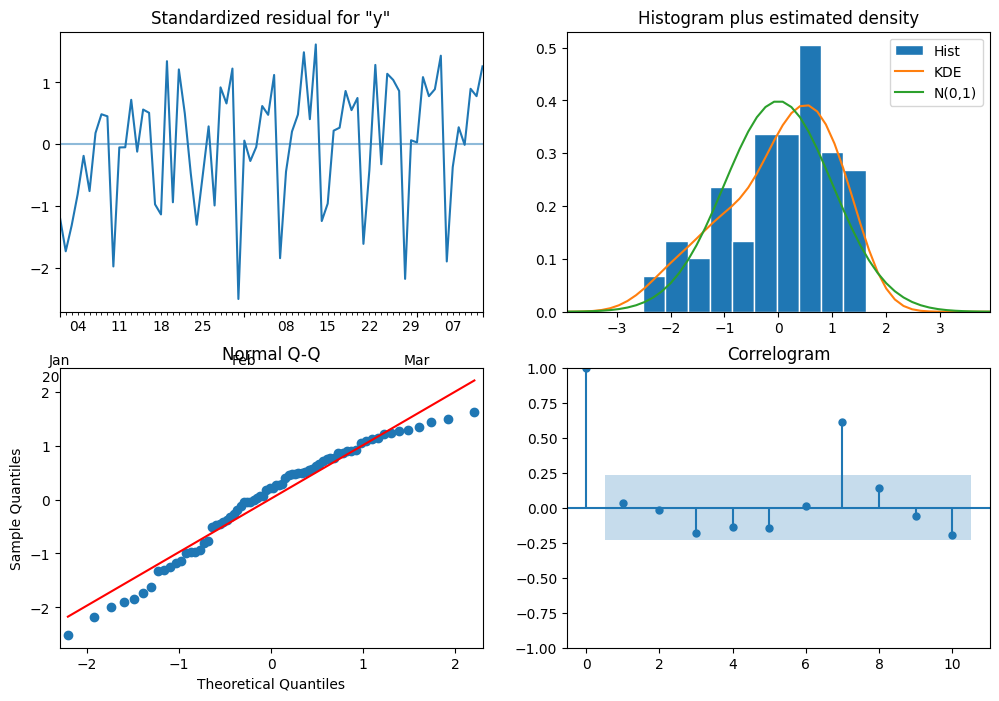

In [42]:
# Diagnostic plots
arima_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [43]:
model_sarima = sm.tsa.statespace.SARIMAX(train_ts, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
sarima_fit = model_sarima.fit(method='bfgs')

print(sarima_fit.summary())

         Current function value: 11.422825
         Iterations: 50
         Function evaluations: 53
         Gradient evaluations: 53
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   72
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -822.443
Date:                           Sun, 01 Dec 2024   AIC                           1654.887
Time:                                   23:42:42   BIC                           1666.270
Sample:                               01-01-2016   HQIC                          1659.418
                                    - 03-12-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1397: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

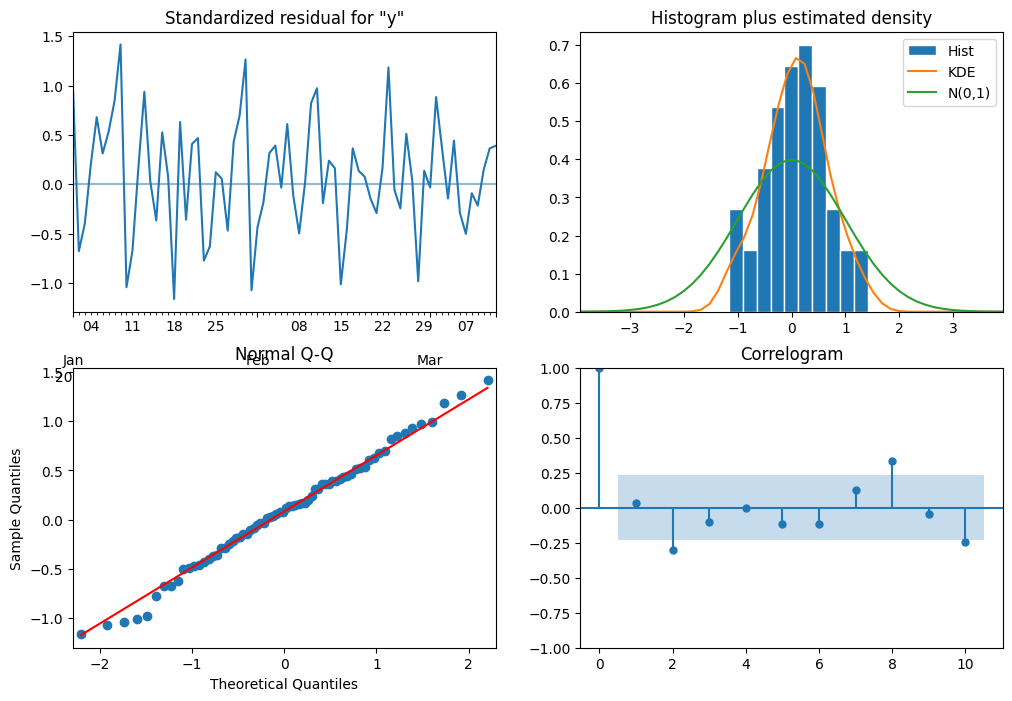

In [44]:
sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

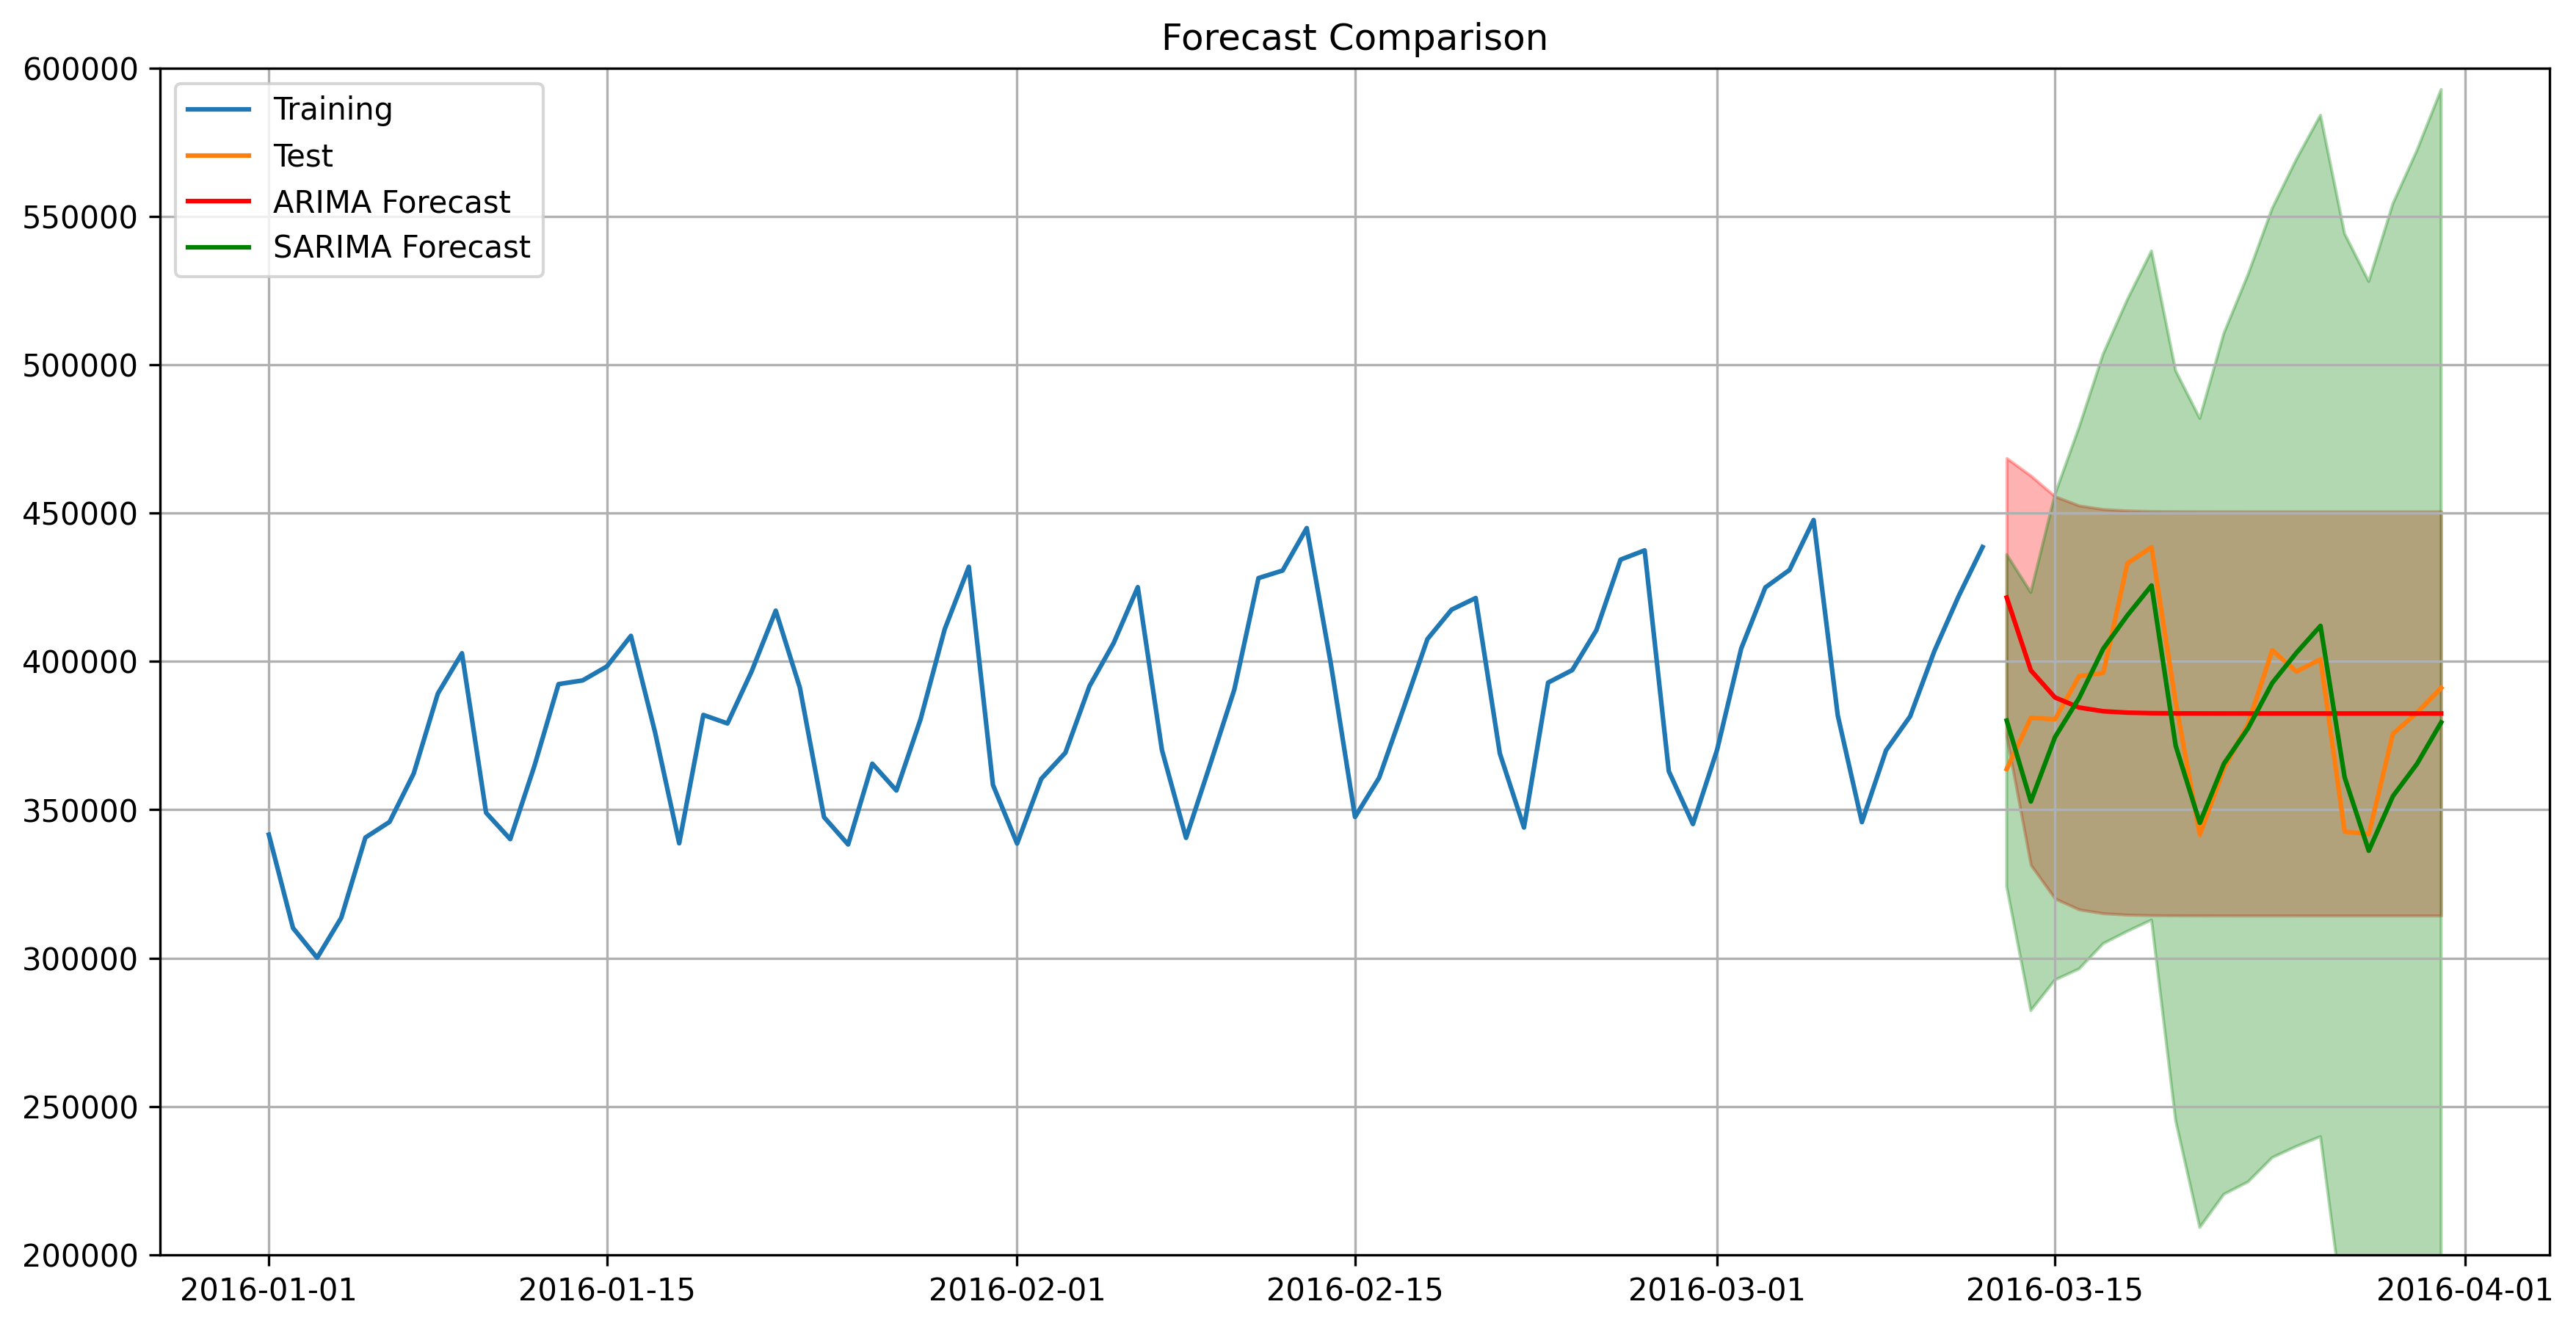

In [46]:
forecast_arima = arima_fit.get_forecast(steps=20)
forecast_sarima = sarima_fit.get_forecast(steps=20)

results = {
    'ARIMA': (forecast_arima.predicted_mean, forecast_arima.se_mean, forecast_arima.conf_int()),
    'SARIMA': (forecast_sarima.predicted_mean, forecast_sarima.se_mean, forecast_sarima.conf_int())
}

arima_fc_series = pd.Series(results['ARIMA'][0], index=test_ts.index)
sarima_fc_series = pd.Series(results['SARIMA'][0], index=test_ts.index)

arima_lower_series = pd.Series(results['ARIMA'][2].iloc[:, 0], index=test_ts.index)
arima_upper_series = pd.Series(results['ARIMA'][2].iloc[:, 1], index=test_ts.index)

sarima_lower_series = pd.Series(results['SARIMA'][2].iloc[:, 0], index=test_ts.index)
sarima_upper_series = pd.Series(results['SARIMA'][2].iloc[:, 1], index=test_ts.index)

plt.figure(figsize=(14, 7), dpi=300)
plt.plot(train_ts, label='Training')
plt.plot(test_ts, label='Test')
plt.plot(arima_fc_series, label='ARIMA Forecast', color='red')
plt.plot(sarima_fc_series, label='SARIMA Forecast', color='green')
plt.ylim(200000, 600000)
plt.fill_between(arima_lower_series.index, arima_lower_series, arima_upper_series, color='red', alpha=0.3)
plt.fill_between(sarima_lower_series.index, sarima_lower_series, sarima_upper_series, color='green', alpha=0.3)
plt.title('Forecast Comparison')
plt.legend(loc='upper left', fontsize=10)
plt.grid()
plt.show()

# plt.figure(figsize=(14, 7))
# plt.plot(ts_daily_trips, label='Observed')
# plt.plot(forecast_arima.predicted_mean.index, forecast_arima.predicted_mean.values, label='ARIMA Forecast', color='red')
# plt.fill_between(forecast_arima_ci.index, forecast_arima_ci.iloc[:, 0], forecast_arima_ci.iloc[:, 1], color='red', alpha=0.3)
# plt.plot(forecast_sarima.predicted_mean.index, forecast_sarima.predicted_mean.values, label='SARIMA Forecast', color='green')
# plt.fill_between(forecast_sarima_ci.index, forecast_sarima_ci.iloc[:, 0], forecast_sarima_ci.iloc[:, 1], color='green', alpha=0.3)
# plt.title('Forecast Comparison')
# plt.xlabel('Date')
# plt.ylabel('Number of Trips')
# plt.legend()
# plt.grid()
# plt.show()

## Hour based analysis

Escludiamo il file CSV relativo a gennaio 2015 in modo tale da ottenere una sottosezione dell'intero dataset relativa al periodo gennaio2016-febbario2016. In questo modo, in quell'intervallo i dati potranno essere aggragati su base oraria con intervalli uniformi tra ogni osservazione

In [47]:
# Specificare i file rilevanti per gennaio, febbraio e marzo 2016
hour_dfs = [pd.read_csv(f, usecols=columns, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']) 
            for f in file_paths]
hour_df = pd.concat(hour_dfs, ignore_index=True)

In [48]:
# Rimuovere righe con valori nulli
hour_df.dropna(subset=columns, inplace=True)

# Filtrare viaggi con valori negativi o anomali
hour_df = hour_df[(hour_df['trip_distance'] > 0) & 
                  (hour_df['fare_amount'] > 0) & 
                  (hour_df['total_amount'] > 0)]

# Calcolare la durata del viaggio
hour_df['trip_duration'] = (hour_df['tpep_dropoff_datetime'] - hour_df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Filtrare viaggi con durata negativa o eccessiva (>4 ore)
hour_df = hour_df[(hour_df['trip_duration'] > 0) & (hour_df['trip_duration'] < 240)]

In [49]:
# Creare un indice temporale arrotondando al più vicino inizio dell'ora
hour_df['pickup_hour'] = hour_df['tpep_pickup_datetime'].dt.floor('H')

# Aggregare il numero di viaggi per ogni ora
hourly_trips = hour_df.groupby('pickup_hour').size()

# Trasformare in una serie temporale con frequenza fissa
hourly_ts = hourly_trips.asfreq('H', fill_value=0)

# Fill all the hours of January 23-24-25-26, 2016 with the average of the corresponding hours of the corresponding days-of-week in the rest of the dataset
# NOT the average of the corresponding days-of-week, but the average of the corresponding hours
# Riempimento delle ore mancanti basato su medie dello stesso giorno della settimana
for i in range(24):
    hourly_ts[f'2016-01-23 {i:02d}:00:00'] = hourly_ts[
        (hourly_ts.index.hour == i) & (hourly_ts.index.dayofweek == 5)
    ].mean()
    hourly_ts[f'2016-01-24 {i:02d}:00:00'] = hourly_ts[
        (hourly_ts.index.hour == i) & (hourly_ts.index.dayofweek == 6)
    ].mean()


# Train and test
train_size = int(len(hourly_ts) * 0.8)
train_hourly_ts = hourly_ts[:train_size]
test_hourly_ts = hourly_ts[train_size:]

/var/folders/hx/spnwlsh16j34k7bqrtl81q3m0000gn/T/ipykernel_66520/180283675.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21406.846153846152' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hourly_ts[f'2016-01-23 {i:02d}:00:00'] = hourly_ts[


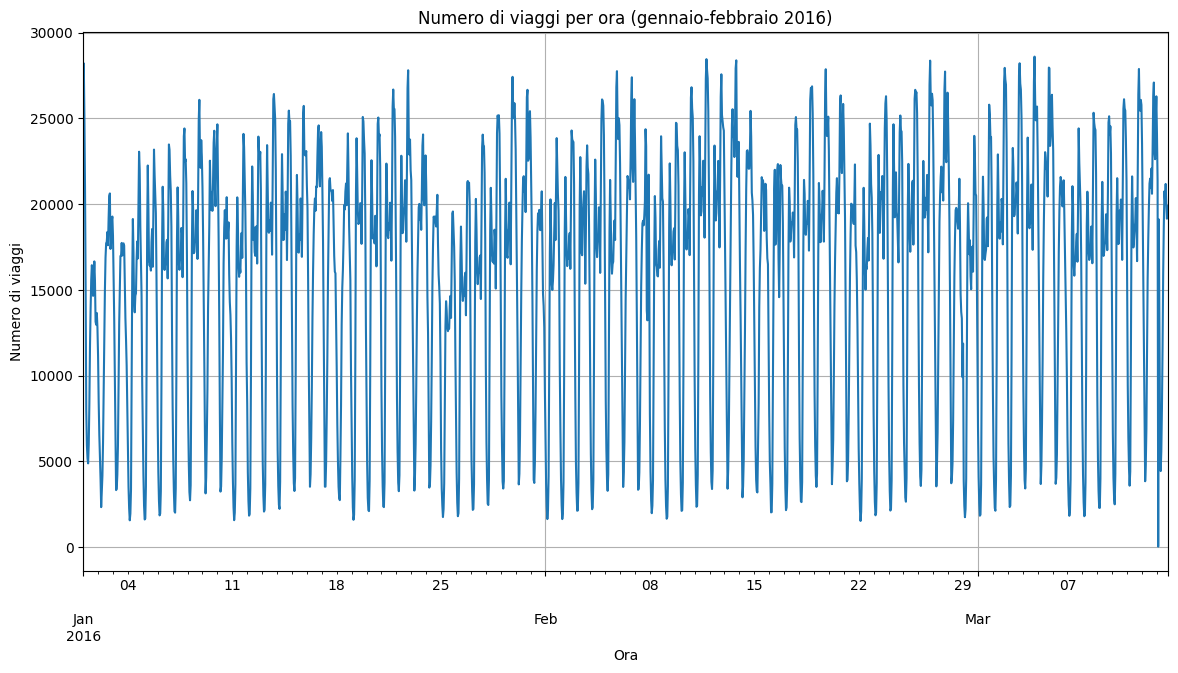

In [50]:
plt.figure(figsize=(14, 7))
train_hourly_ts.plot()
plt.title('Numero di viaggi per ora (gennaio-febbraio 2016)')
plt.xlabel('Ora')
plt.ylabel('Numero di viaggi')
plt.grid()
plt.show()


In [51]:
print("\n[TEST SULLA SERIE ORIGINALE]")
test_stationarity_with_interpretation(train_hourly_ts)


[TEST SULLA SERIE ORIGINALE]
=== Augmented Dickey-Fuller Test ===
ADF Statistic: -4.6006
p-value: 0.00012886333990809926
Critical Values:
   1%: -3.4342
   5%: -2.8632
   10%: -2.5677

✅ La serie è stazionaria


In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

acf_values = acf(train_hourly_ts, nlags=30)
pacf_values = pacf(train_hourly_ts, nlags=30)
print("ACF:", acf_values)
print("PACF:", pacf_values)

ACF: [ 1.          0.90251235  0.69212042  0.4488545   0.20671472 -0.01778762
 -0.20010293 -0.32179146 -0.37425793 -0.36490343 -0.32164677 -0.28129939
 -0.26200123 -0.26249376 -0.28246726 -0.30896609 -0.31449121 -0.27409459
 -0.17980365 -0.03365619  0.14948266  0.34904861  0.55043993  0.72913823
  0.81551314  0.75896372  0.60402915  0.41671548  0.2185526   0.01828904
 -0.16256652]
PACF: [ 1.          0.90302926 -0.6640803   0.078134   -0.20336691 -0.10122839
  0.01153511 -0.01592304  0.04852623 -0.01181137 -0.12570052 -0.19478704
 -0.12858729 -0.10525076 -0.16290195 -0.01139688  0.06443477  0.10517529
  0.10150142  0.14565205  0.11597298  0.18390726  0.32089608  0.29835808
 -0.19033003 -0.29550711  0.18973811  0.18928994 -0.03393237 -0.04943298
 -0.048998  ]


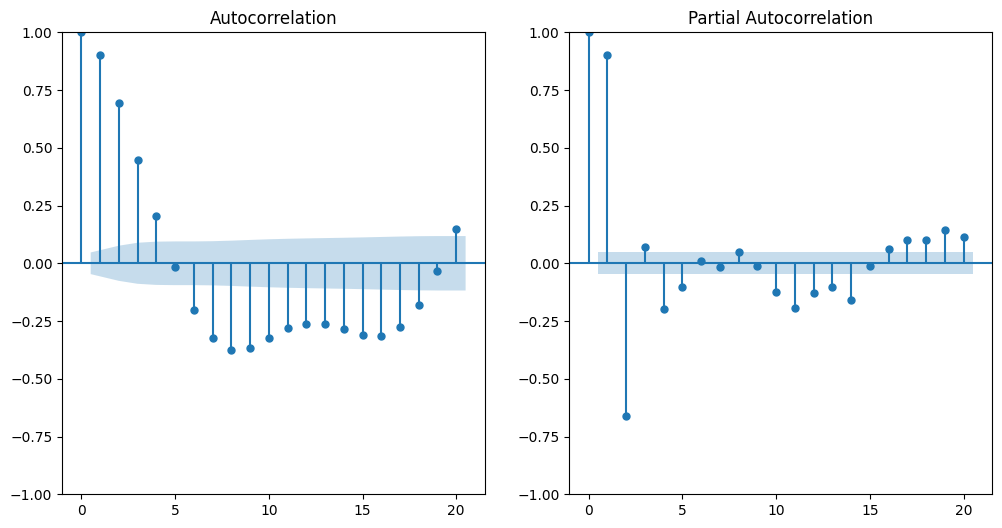

In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_hourly_ts, ax=plt.gca(), lags=20)
plt.subplot(122)
plot_pacf(train_hourly_ts, ax=plt.gca(), lags=20)
plt.show()

In [55]:
hourly_arima_model = ARIMA(train_hourly_ts, order=(1, 0, 1))

hourly_arima_fit = hourly_arima_model.fit()

print("\n=== ARIMA Model Summary ===")
print(hourly_arima_fit.summary())


=== ARIMA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1747
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -16135.310
Date:                Sun, 01 Dec 2024   AIC                          32278.621
Time:                        23:52:00   BIC                          32300.484
Sample:                    01-01-2016   HQIC                         32286.703
                         - 03-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.587e+04    662.957     23.940      0.000    1.46e+04    1.72e+04
ar.L1          0.8457      0.016     52.694      0.000       0.814       0.877
ma.L1          0.6122  

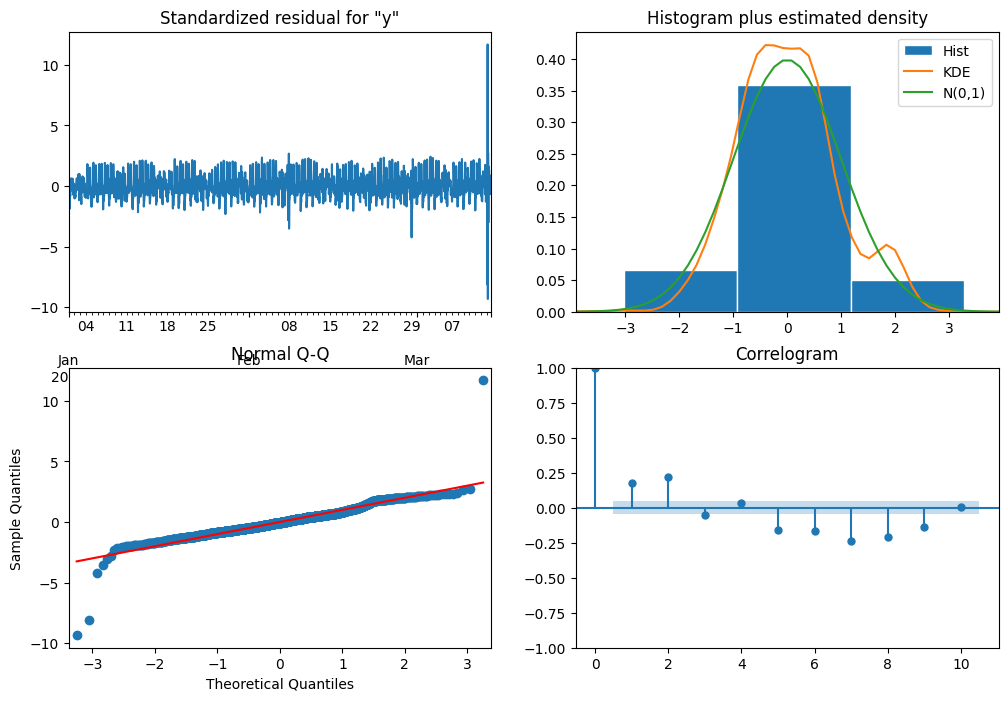

In [56]:
hourly_arima_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [57]:
# Applicare la trasformazione logaritmica
hourly_ts_log = np.log1p(hourly_ts)

# Modello SARIMA
hourly_model_sarima = sm.tsa.statespace.SARIMAX(hourly_ts_log, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
hourly_sarima_fit = hourly_model_sarima.fit()

print(hourly_sarima_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68708D-01    |proj g|=  3.56357D-01

At iterate    5    f=  2.26897D-01    |proj g|=  1.34046D-01

At iterate   10    f=  1.31464D-01    |proj g|=  2.25999D-02

At iterate   15    f=  1.30836D-01    |proj g|=  2.61452D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   1.513D-04   1.308D-01
  F =  0.13083599119978334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

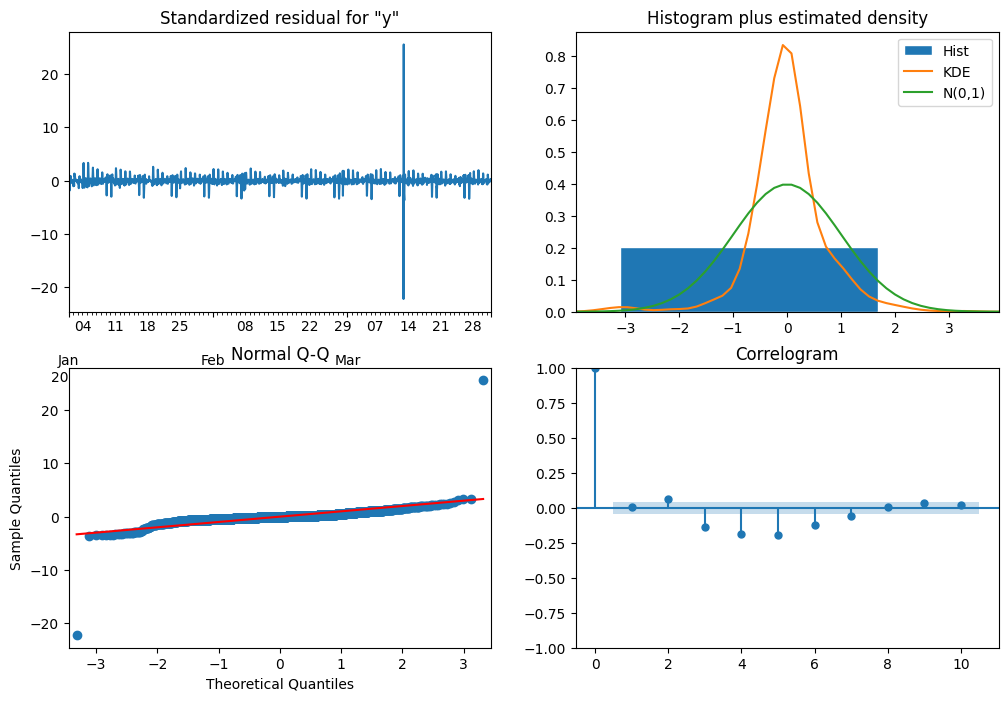

In [58]:
hourly_sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

ARIMA RMSE: 7151.63, MAE: 5924.45
SARIMA RMSE: 10888.31, MAE: 9358.10


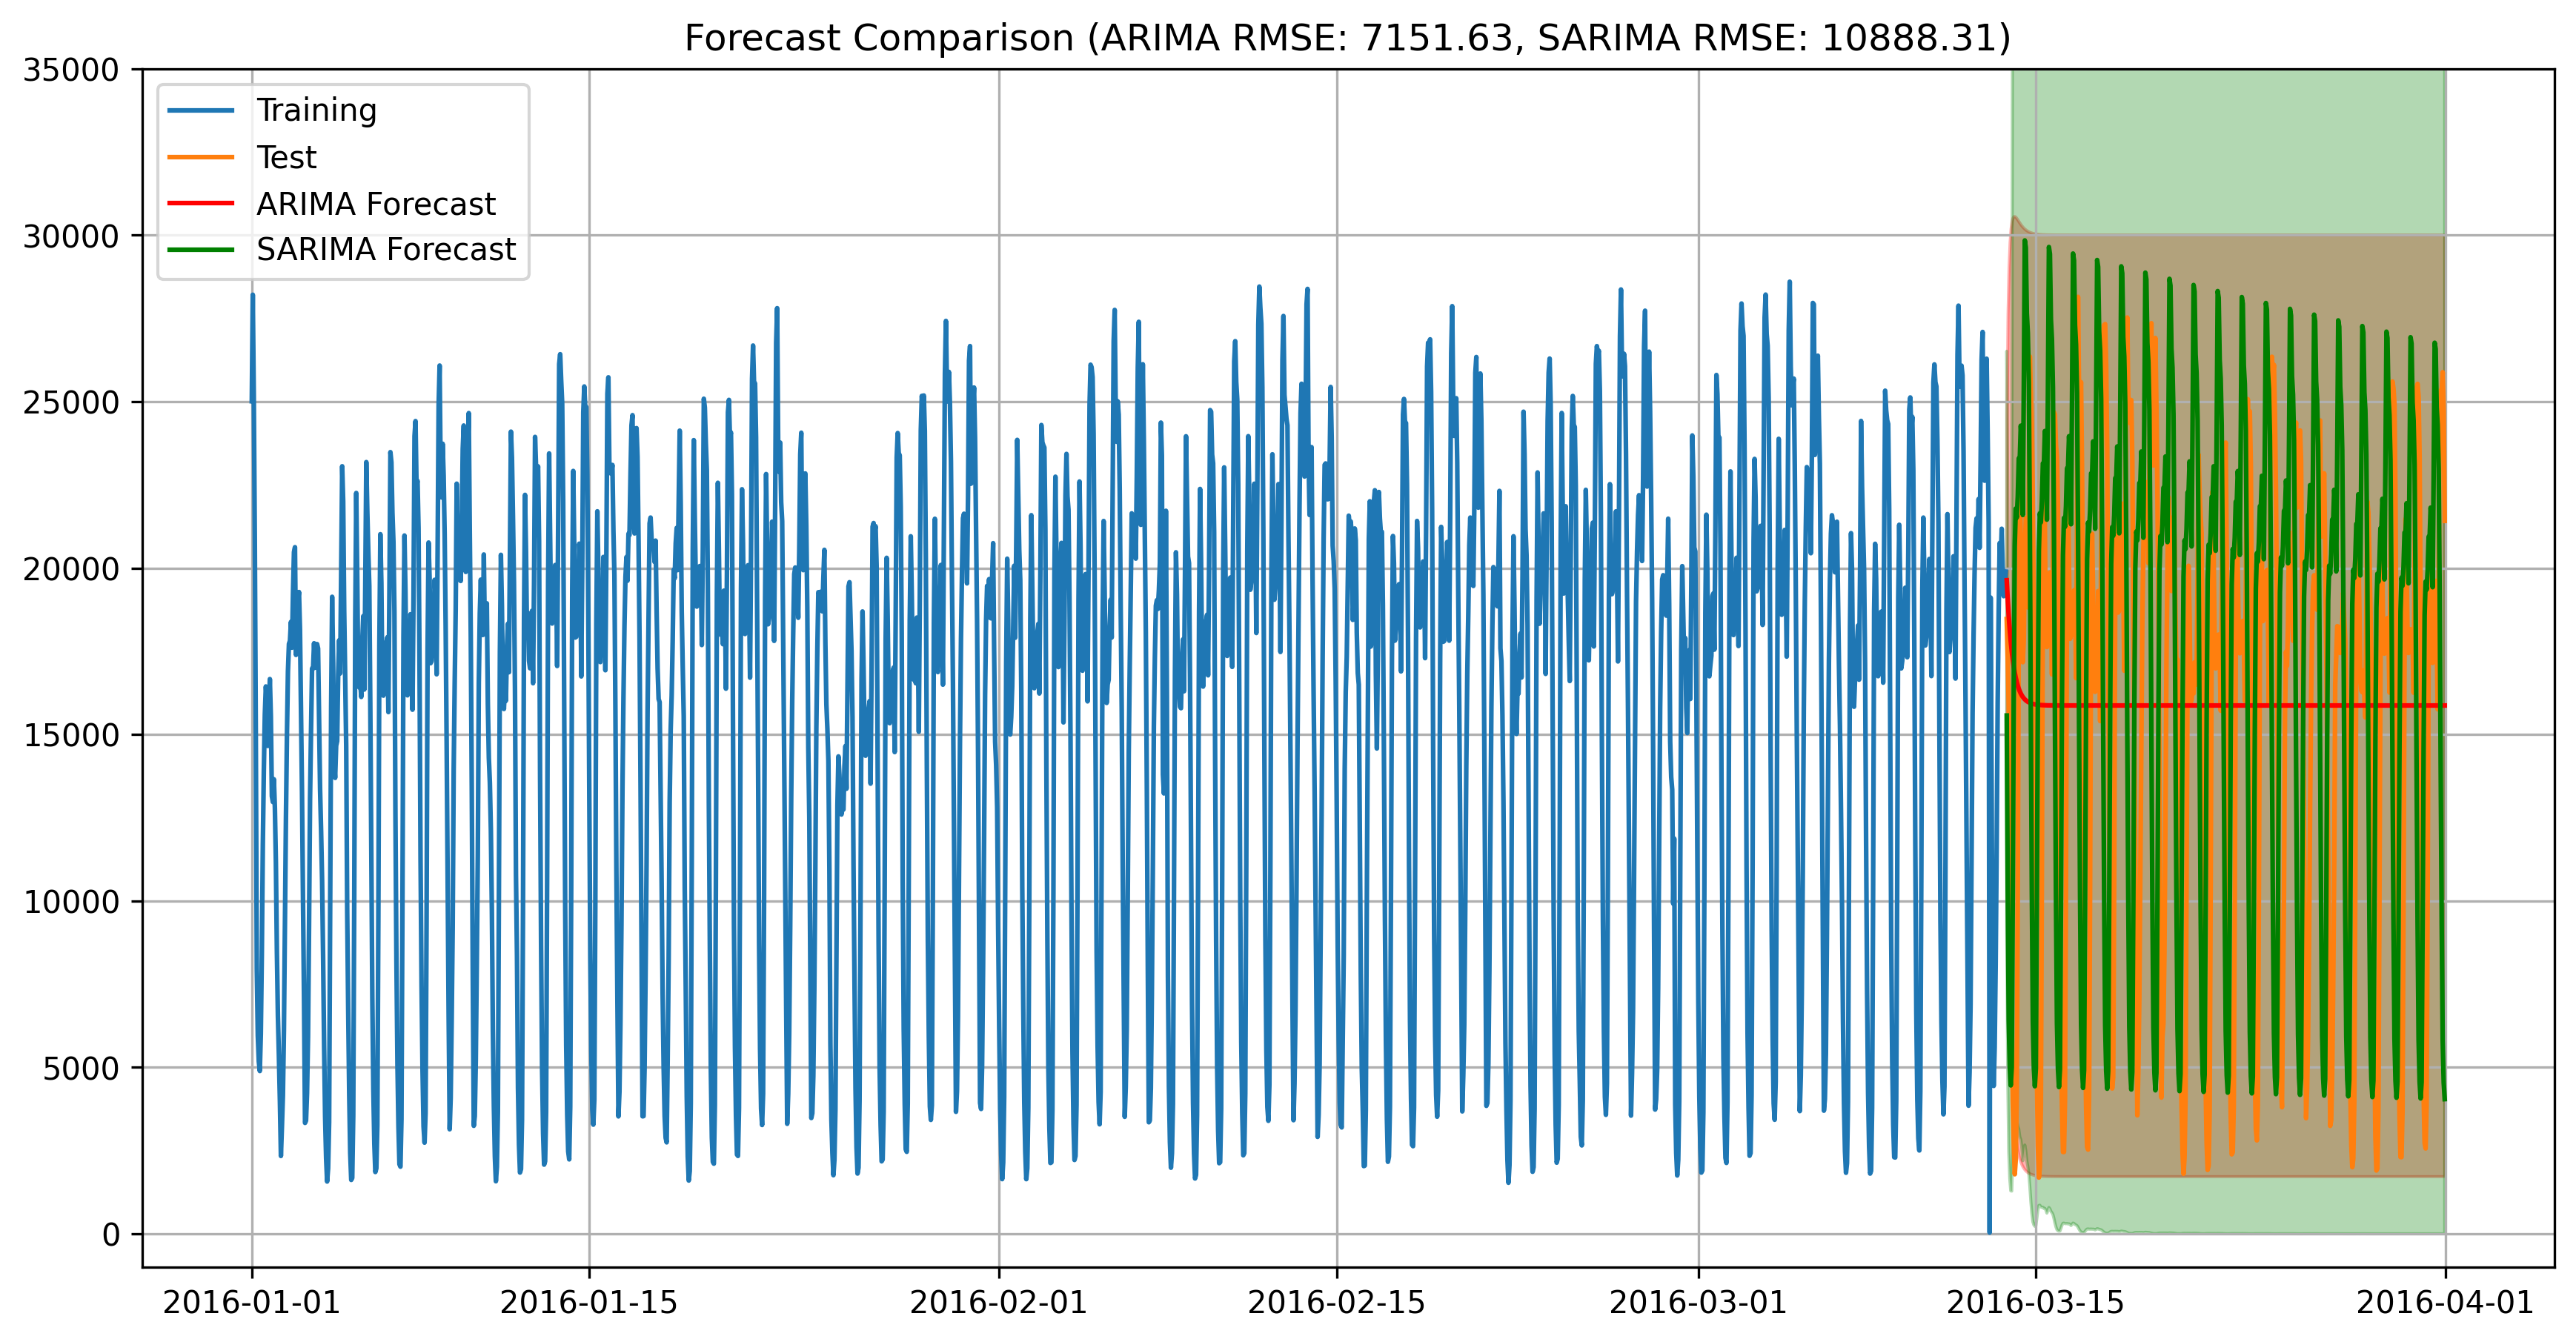

In [64]:
hourly_forecast_arima = hourly_arima_fit.get_forecast(steps=len(test_hourly_ts))
hourly_forecast_sarima_log = hourly_sarima_fit.get_forecast(steps=len(test_hourly_ts))
hourly_forecast_sarima = np.expm1(hourly_forecast_sarima_log.predicted_mean)
hourly_forecast_sarima_se = hourly_forecast_sarima_log.se_mean
hourly_forecast_sarima_ci = np.expm1(hourly_forecast_sarima_log.conf_int())

# Allineare gli indici delle previsioni con il test set
arima_fc_series = pd.Series(hourly_forecast_arima.predicted_mean.values, index=test_hourly_ts.index)
sarima_fc_series = pd.Series(hourly_forecast_sarima.values, index=test_hourly_ts.index)

arima_lower_series = pd.Series(hourly_forecast_arima.conf_int().iloc[:, 0].values, index=test_hourly_ts.index)
arima_upper_series = pd.Series(hourly_forecast_arima.conf_int().iloc[:, 1].values, index=test_hourly_ts.index)

sarima_lower_series = pd.Series(hourly_forecast_sarima_ci.iloc[:, 0].values, index=test_hourly_ts.index)
sarima_upper_series = pd.Series(hourly_forecast_sarima_ci.iloc[:, 1].values, index=test_hourly_ts.index)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcolo delle metriche di errore
arima_rmse = np.sqrt(mean_squared_error(test_hourly_ts, arima_fc_series))
sarima_rmse = np.sqrt(mean_squared_error(test_hourly_ts, sarima_fc_series))
arima_mae = mean_absolute_error(test_hourly_ts, arima_fc_series)
sarima_mae = mean_absolute_error(test_hourly_ts, sarima_fc_series)

print(f"ARIMA RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")
print(f"SARIMA RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}")

plt.figure(figsize=(14, 7), dpi=300)
plt.plot(train_hourly_ts, label='Training')
plt.plot(test_hourly_ts, label='Test')
plt.plot(arima_fc_series, label='ARIMA Forecast', color='red')
plt.plot(sarima_fc_series, label='SARIMA Forecast', color='green')
plt.ylim(-1000, 35000)
plt.fill_between(arima_lower_series.index, arima_lower_series, arima_upper_series, color='red', alpha=0.3)
plt.fill_between(sarima_lower_series.index, sarima_lower_series, sarima_upper_series, color='green', alpha=0.3)
plt.title(f'Forecast Comparison (ARIMA RMSE: {arima_rmse:.2f}, SARIMA RMSE: {sarima_rmse:.2f})')
plt.legend(loc='upper left', fontsize=10)
plt.grid()
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91657D-01    |proj g|=  1.44178D-01

At iterate    5    f=  2.71311D-01    |proj g|=  7.64623D-02

At iterate   10    f=  2.47641D-01    |proj g|=  8.74121D-02

At iterate   15    f=  2.27093D-01    |proj g|=  5.10835D-02

At iterate   20    f=  2.26665D-01    |proj g|=  1.98897D-03

At iterate   25    f=  2.26505D-01    |proj g|=  1.80626D-03

At iterate   30    f=  2.26497D-01    |proj g|=  9.73267D-05

At iterate   35    f=  2.26496D-01    |proj g|=  4.82333D-04

At iterate   40    f=  2.26477D-01    |proj g|=  1.33351D-02

At iterate   45    f=  2.26411D-01    |proj g|=  1.77646D-03


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.26404D-01    |proj g|=  8.17244D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   8.172D-04   2.264D-01
  F =  0.22640424036544660     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


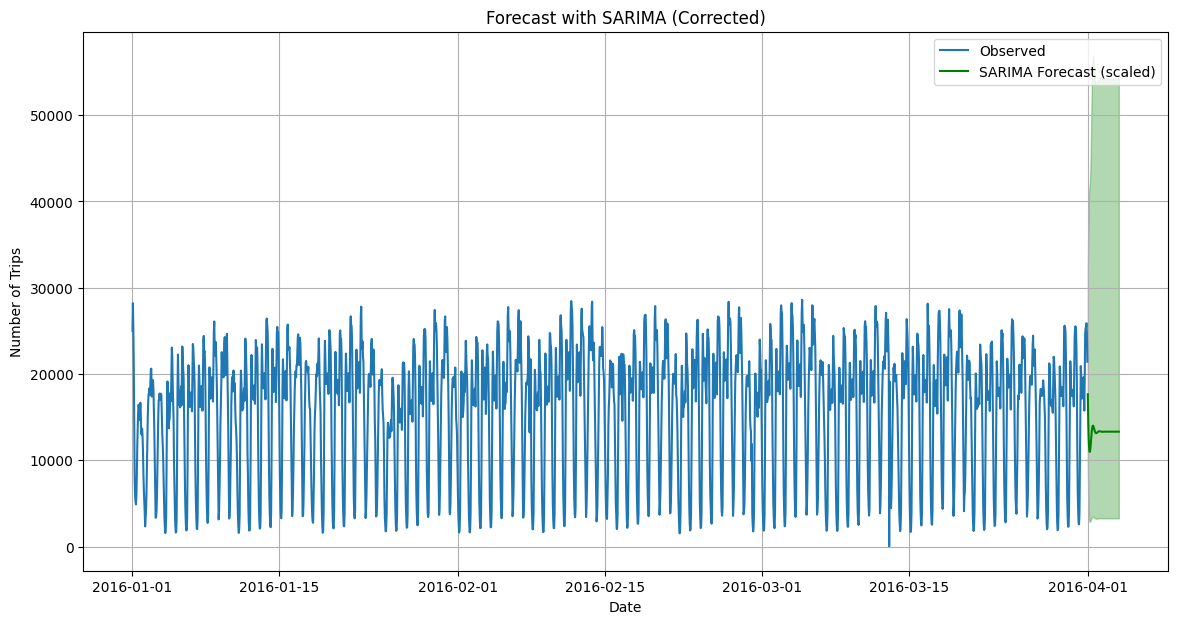

In [65]:
# Scaling dei dati
hourly_ts_scaled = np.log1p(hourly_ts)

# SARIMA con dati scalati
hourly_model_sarima = sm.tsa.statespace.SARIMAX(hourly_ts_scaled, 
                                                order=(4, 1, 2), 
                                                seasonal_order=(0, 0, 1, 7))
hourly_sarima_fit = hourly_model_sarima.fit()

# Previsioni
forecast_sarima_scaled = hourly_sarima_fit.get_forecast(steps=24*3)
forecast_sarima_ci_scaled = forecast_sarima_scaled.conf_int()

# Ritorno ai dati originali (invertire il log scaling)
forecast_sarima = np.expm1(forecast_sarima_scaled.predicted_mean)
forecast_sarima_ci = np.expm1(forecast_sarima_ci_scaled)

# Visualizzazione
plt.figure(figsize=(14, 7))
plt.plot(hourly_ts, label='Observed')
plt.plot(forecast_sarima.index, forecast_sarima.values, label='SARIMA Forecast (scaled)', color='green')
plt.fill_between(forecast_sarima_ci.index, 
                 forecast_sarima_ci.iloc[:, 0], 
                 forecast_sarima_ci.iloc[:, 1], 
                 color='green', alpha=0.3)
plt.title('Forecast with SARIMA (Corrected)')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid()
plt.show()
